Todo: 
 - seasonal averages
 - Verify against station data
 - Investigate urban fraction field
 - Max and mim fields
 - Check out figure 4 and 16 of the report
   
Definition of the UHI

Urban fraction vs temperature graph, dots for station 
/runoff/winger/Output/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/Samples/StLaurent_1km_SL2.5_ERA5_advHU_step0
Usually, there should be a directory ending on *_step0 in the Samples directory. The field 2V, level 21 of the pm-file in that directory contains the urban fraction. You can use xrec to observe it as long as you've ssh'd using -YC
 


# <b> Analysis Scripts for Montréal Urban Heat Waves </b>

The purpose of this file is to keep a record of scripts used to analyse CRCM6/GEM5 model output for the analysis of the urban heat island effect on historical heat waves. It includes the setup, analysis of observation and model output, and the code for plotting map data for the project.

# Table of Contents
1. <a href="#setup">Setup</a>
    - <a href="#11-imports">1.1 Imports and Libraries</a>
    - <a href="#12-functions">1.2 Functions</a>
    - <a href="#13-datasets">1.3 Datasets</a>
2. <a href="#station-observations-and-model-output-data-visualisation">Station Observations and Model Output Data Visualisation</a>
    - <a href="#21-station-observations">2.1 Station Observations</a>
    - <a href="#22-comparison-of-stations-to-simulation-output">2.2 Comparison of Stations to Simulation Output</a>
    - <a href="#23-formatting-model-output">2.3 Formatting Model Output</a>

---

# 1. Setup
Common tools used throughout various scripts in the collection, analysis, and display of data throughout the project.

## <a id="11-imports"></a> 1.1 Imports

In [1]:
%matplotlib tk
# !jupyter nbextension enable --py widgetsnbextension
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import pandas as pd
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
import warnings
import math

## <a id="12-functions"></a> 1.2 Functions
Custom functions, classes, tools, cleaned data, usage and reference

In [2]:
#Warning formatting
def custom_warning_format(message, category, filename, lineno, file=None, line=None):
    return f"{category.__name__}: {message}\n"

# Setting the custom warning format
warnings.formatwarning = custom_warning_format

In [3]:
#For projections of all map data used here
rotated_pole = ccrs.RotatedPole(pole_longitude=np.float32(106.425), pole_latitude=np.float32(44.5))

#The time period for all data to be read
time_domain = slice('1999-01-01', '2021-12-31')
reduced_time_domain = False

#Seasonal bins: winter, spring, summer, fall
seasons = ['DJF','MAM','JJA','SON']
allSeasons = ['DJF', 'MAM', 'JJA', 'SON', 'All Seasons']

In [4]:
#All imported station data as xarray
pavics = xr.open_dataset("https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml") 

In [5]:
class Station:
    """
    A class holding key information about an instance of a particular weather station.

    Attributes
    ----------
    lattitude, longitude : float
        The real-life position of the weather station.
    rotated_lat, rotated_lon : float
        The rotated projection of the station's coordinates.

    Functions
    ----------
    get_time_series : array_like
        The time series of the field at the station's location
    """
    
    name = ""
    lattitude = 0
    longitude = 0
    rotated_lat = 0
    rotated_lon = 0
    ID = ''
    daily_station_data = None
    station_lat = 0.
    station_lon = 0.
    distance_to_nearest_station_km = -1
    
    def __init__(self,lat,lon):
        self.lattitude = lat
        self.longitude = lon
        self.rotated_lon, self.rotated_lat = rotated_pole.transform_point(lon, lat, ccrs.PlateCarree())
        
        #Determine the closest station to the inputted (lat,lon) pair:
        
        #Conversion to radians
        lat_r = np.radians(lat)
        lon_r = np.radians(lon)
        lat_options = np.radians(pavics['lat'].values)
        lon_options = np.radians(pavics['lon'].values)
        
        #Arc differences between selected and potential latitudes and longitudes
        dlat = lat_r - lat_options
        dlon = lon_r - lon_options
        
        #Haversine formula to find the distance to each station
        a = np.sin(dlat/2)**2 + np.cos(lat_r) * np.cos(lat_options) * np.sin(dlon/2)**2
        distances = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) * 6371
        
        #Index of nearest station
        nearest_station_index = np.argmin(distances)
        
        #
        self.daily_station_data = pavics.isel(station=nearest_station_index)
        self.name = str(self.daily_station_data['station_name'].values)
        self.station_lat = float(self.daily_station_data['lat'])
        self.station_lon = float(self.daily_station_data['lon'])
        self.distance_to_nearest_station_km = distances[nearest_station_index]
        self.station_records = self.daily_station_data['time']
        
        
        if self.distance_to_nearest_station_km > 3 :
            warnings.warn(f'Nearest station {self.name} is {round(self.distance_to_nearest_station_km)} km away from ({self.lattitude},{self.longitude}). Is this intended?')
        
        
#         daily_station_data =      
        
#     def __init__(self,station_id):
#         self.lattitude = lat
#         self.longitude = lon
#         self.rotated_lon, self.rotated_lat = rotated_pole.transform_point(lon, lat, ccrs.PlateCarree())
#         self.ID = station_id
#         if(self.ID!=''):
#             daily_station_data = pavics.isel(station='station_id')       

#             daily_station_temp = xr.open_dataset("https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml")
#             self.daily_station_data  = daily_station_temp.sel(station=station_id)
        
            
        
    
    def get_time_series(self,field):
        """
        Retrieves the time series of the field at the latitude and longitude of the station. 
        
        Parameters
        ----------
        field : array_like
            Minimum, maximum, or average temperature, or humidity, spatial data in time.
        
        Returns
        ----------
        array_like
            Time series of the field at the station's location
        
        """
        
        return field.interp(rlon=self.rotated_lon, rlat=self.rotated_lat) 
    
        

In [6]:
def seasonalMeans(dataset):
    """
    Calculates time average of a field for each season.

    Parameters
    ----------
    dataset : xarray.DataSet()
        The time series of the temperature of humidity field.

    Returns
    ----------
    xarray.DataSet()
        The seasonal means of the field.
    """

    return dataset.groupby('time.season').mean('time')

## <a id="13-datasets"></a> 1.3 Datasets

For tas datasets, the collection is hourly, for tasmin and tasmax, it's daily.

In [7]:
paths_ERA5_noTEB = glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/*tas.nc')
tas_ERA5_noTEB = xr.open_mfdataset(paths_ERA5_noTEB)
# tas_ERA5_noTEB

In [8]:
paths_ERA5_noTEB = glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/*tasmax.nc')
tasmax_ERA5_noTEB = xr.open_mfdataset(paths_ERA5_noTEB)
# tasmax_ERA5_noTEB

In [9]:
paths_ERA5_noTEB = glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/*tasmin.nc')
tasmin_ERA5_noTEB = xr.open_mfdataset(paths_ERA5_noTEB)
# tasmin_ERA5_noTEB

In [10]:
paths_ERA5_TEB = glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/*tas.nc')
tas_ERA5_TEB = xr.open_mfdataset(paths_ERA5_TEB)
# tas_ERA5_TEB

In [11]:
paths_ERA5_TEB = glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/*tasmax.nc')
tasmax_ERA5_TEB = xr.open_mfdataset(paths_ERA5_TEB)
# tasmax_ERA5_TEB

In [12]:
paths_ERA5_TEB = glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/*tasmin.nc')
tasmin_ERA5_TEB = xr.open_mfdataset(paths_ERA5_TEB)
# tasmax_ERA5_TEB

All datasets from the ERA5-fed simulation output from 1999-2020 have been loaded into xarray datastructures. The corresponding rotated latitude and longitude of all output is as follows:

In [13]:
rlat = tas_ERA5_noTEB['rlat'].values
rlon = tas_ERA5_noTEB['rlon'].values

Dictionaries to hold field information for easier access in later subroutines based on the key used. Ensure all fields end with the specification of whether they were generated from TEB or nonTEB output.

In [14]:

fields = {
    "tas_ERA5_TEB" : tas_ERA5_TEB,
    "tasmax_ERA5_TEB" : tasmax_ERA5_TEB,
    "tasmin_ERA5_TEB" : tasmin_ERA5_TEB,
    "tas_ERA5_noTEB" : tas_ERA5_noTEB,
    "tasmax_ERA5_noTEB" : tasmax_ERA5_noTEB,
    "tasmin_ERA5_noTEB" : tasmin_ERA5_noTEB
}

#Keys to access noTEB fields from the fields dictionary
noTEB_keys = [i for i in fields.keys() if i.endswith('_noTEB')]
TEB_keys = [i for i in fields.keys() if i.endswith('_TEB')]
tas_keys = [i for i in fields.keys() if i.startswith('tas_')]
tasmax_keys = [i for i in fields.keys() if i.startswith('tasmax_')]
tasmin_keys = [i for i in fields.keys() if i.startswith('tasmin_')]

summer_fields = {}
winter_fields = {}
spring_fields = {}
autumn_fields = {}
for i in fields.keys():
    grouped = fields[i].groupby("time.season")
    summer_fields[i] = grouped['JJA']
    winter_fields[i] = grouped['DJF']
    spring_fields[i] = grouped['MAM']
    autumn_fields[i] = grouped['SON']

It was found that one of the simulations was behaving erratically after 2020, so we'll choose a temporal subset of the data for each field which excludes this.

In [15]:
if reduced_time_domain:
    for key, i in fields.items():
        #Re-specification of the time domain of all fields
        globals()[key] = i.sel(time=time_domain)

    #The same should be done for the recorded station data in section 2.2

## <a id="14-urban-fraction-field"></a>1.4 Urban Fraction Field 
The urban fraction is a static field parameterisation for TEB, and should be the largest spatial indicator for differences between a TEB and non-TEB run.

In [16]:
static_fields = xr.open_mfdataset(glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_step0.nc'))
urban_fraction_2d = static_fields['furban'].isel(lev=5) #5? There was nothing in the metadata to tell me which level :(

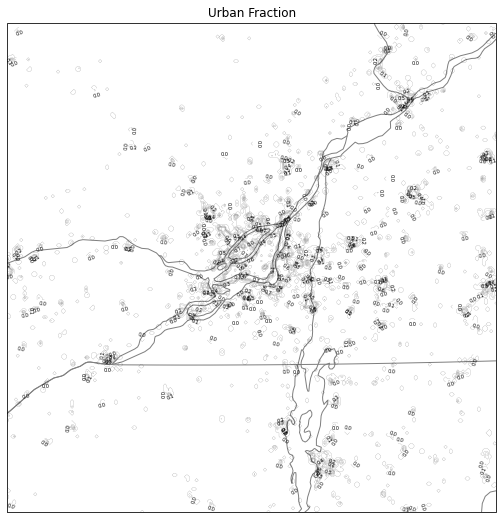

In [17]:
plt.figure(figsize=(15, 9))
data = urban_fraction_2d
ax = plt.subplot(projection=rotated_pole)
ax.add_feature(cfeature.BORDERS,edgecolor='grey')
ax.add_feature(cfeature.LAKES, edgecolor='grey', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='grey', facecolor='none')
ax.add_feature(cfeature.COASTLINE,edgecolor='grey')

mesh = ax.contour(rlon,rlat, data, transform=rotated_pole,colors='k',linewidths=0.1,levels = np.arange(0.0, 1.0, 0.1))
ax.clabel(mesh,inline=True,fontsize=5,fmt="%.1f")
# plt.colorbar(mesh, orientation='vertical')
plt.title('Urban Fraction')
plt.show()

# 2. Station Observations and Model Output Data Visualisation
<!-- In this section:
- <a href="#21-station-observations">2.1 Station Observations</a>
- <a href="#22-comparison-of-stations-to-simulation-output">2.2 Comparison of Stations to Simulation Output</a>
- <a href="#23-formatting-model-output">2.3 Formatting Model Output</a> -->

## <a id="21-station-observations"></a>2.1 Station Observations
Multiyear monthly means to do mean annual cycles, annual means and seasonal means of temperature using station observations. Importing through Ouranos PAVICS

## <a id="22-comparison-of-stations-to-simulation-output"></a>2.2 Comparison of Stations to Simulation Output
Select the closest grid cells of the simulations at 1km with and without TEB from few weather stations and compute multiyear monthly means to do mean annual cycles, annual means and seasonal means of temperature. 

On implementation, some of the PAVICS data did not contain a station time series for a particular station and have therefore been commented out (i.e. if a latitude,longitude pair specified is greater than 3km from an existing station where PAVICS data is recorded, a user warning is thrown).


### McTavish

Latitude:
45°30'17.070" N
Longitude:
73°34'45.000" W
Elevation:
72.80 m
Climate ID:
7024745
WMO ID:
71612
TC ID:
WTA


### Mirabel

Latitude:
45°40'00.000" N
Longitude:
74°02'00.000" W
Elevation:
82.60 m
Climate ID:
7035290
WMO ID:
TC ID:
YMX


### La Prairie

Latitude:
45°23'00.000" N
Longitude:
73°26'00.000" W
Elevation:
30.00 m
Climate ID:
7024100
WMO ID:
TC ID:

### Saint-Hubert 

Latitude:
45°31'00.000" N
Longitude:
73°25'00.000" W
Elevation:
27.40 m
Climate ID:
7027322
WMO ID:
71371
TC ID:
YHU

### Mascouche

Latitude:
45°45'00.000" N
Longitude:
73°36'00.000" W
Elevation:
15.20 m
Climate ID:
7014629
WMO ID:
TC ID:


In [17]:
#Some PAVICS data did not contain a station time series for the commented stations below

mctavish = Station(45.504742,-73.579167) 
# mirabel = Station(45.6519,-74.0902) #UserWarning: Nearest station ST JEROME is 17 km away from (45.6519,-74.0902). Is this intended?
# la_prairie = Station(45.4159,-73.4830) #UserWarning: Nearest station MCTAVISH is 12 km away from (45.4159,-73.483). Is this intended?
saint_hubert = Station(45.516667,-73.416667)
# mascouche = Station(45.75,-73.6) #UserWarning: Nearest station RIVIERE DES PRAIRIES is 10 km away from (45.75,-73.6). Is this intended?


#The following stations have been included in lieu of the failed retrievals
st_jerome = Station(45.8,-74.05)
riviere_des_prairies = Station(45.7,-73.5)

# stations = {
#     "McTavish" : mctavish,
#     "Mirabel" : mirabel,
#     "La Prairie" : la_prairie,
#     "Saint-Hubert" : saint_hubert,
#     "Mascouche" : mascouche
# }

stations = {
    mctavish.name : mctavish,
    saint_hubert.name : saint_hubert,
    st_jerome.name : st_jerome,
    riviere_des_prairies.name : riviere_des_prairies
}

if reduced_time_domain:
    #Ensuring the time domain is comparable for all stations as it is to the model output
    for i in stations:
        stations[i].daily_station_data = stations[i].daily_station_data.sel(time=time_domain)


In [18]:
# #Plotting the time series of each station for the TEB and noTEB simulation output

# #The field to plot (such as tas)
# for station_name in stations.keys():
#     for field_name_TEB,field_name_noTEB in zip(TEB_keys,noTEB_keys): 
#         field_TEB = fields[field_name_TEB]
#         field_noTEB = fields[field_name_noTEB]

#         station = stations[station_name]
#         times =  field_TEB['time'].squeeze()

#         station_times = station.daily_station_data['time'].squeeze()
        
#         variable_name = 'tas'
#         #Compare either tas, tasmax, or tasmin
#         if field_name_TEB.startswith('tas_'):
#             station_records = station.daily_station_data['tas'].squeeze() + 273.15
#         if field_name_TEB.startswith('tasmax_'):
#             station_records = station.daily_station_data['tasmax'].squeeze() + 273.15
#             variable_name = 'tasmax'
#         if field_name_TEB.startswith('tasmin_'):
#             station_records = station.daily_station_data['tasmin'].squeeze() + 273.15
#             variable_name = 'tasmin'

#         series_TEB = station.get_time_series(field_TEB)[variable_name]
#         series_noTEB = station.get_time_series(field_noTEB)[variable_name]

#         fig, axes = plt.subplots(figsize=(12, 6))
#         plt.plot(times,series_TEB,label = field_name_TEB)
#         plt.plot(times, series_noTEB, label = field_name_noTEB)
#         plt.plot(station_times,station_records, label = f'station record ({variable_name})')
#         plt.xlabel('Time')
#         plt.ylabel('K')
#         plt.legend()
#         plt.title(f'{station_name}')
#         plt.grid(True)
#         plt.show()
    

## <a id="23-formatting-model-output"></a>2.3 Formatting Model Output
Maps with python of seasonal means, and compute and plot differences between two simulations (with and without TEB)
### 2.3.1 Raw Instantaneous Geospatial Output
Below visualises the output of the simulation, the field evolution in time over the entire domain.

In [ ]:
#contains the dataset to be displayed from the code for the interactive widget that follows
ds = diurnal_cycle.to_dataset(name='tas').rename({"hour": "time"})

In [ ]:
#For plotting and displaying model output contained in ds
def plot_temperature(time_index):
    """
    Plots the temperature field in the Montréal region of interest at a given time index of the ds xarray.Dataset()
    
    Parameters
    -----------
    time_index : int
        Index corresponding to some date within the dataset
    """
#     min_temp = 223.15
#     max_temp = 323.15
    min_temp = -10
    max_temp = 10
    
    plt.figure(figsize=(15, 9))
    data = ds['tas'].isel(time=time_index).squeeze()
    ax = plt.subplot(1, 1, 1, projection=rotated_pole)
    

 
    
    ax.add_feature(cfeature.BORDERS,edgecolor='grey')
    ax.add_feature(cfeature.LAKES, edgecolor='grey', facecolor='none')
    ax.add_feature(cfeature.RIVERS, edgecolor='grey', facecolor='none')
    ax.add_feature(cfeature.COASTLINE,edgecolor='grey')
    mesh = ax.pcolormesh(ds['rlon'], ds['rlat'], data, transform=rotated_pole, cmap='coolwarm',vmin=min_temp,vmax=max_temp)
    plt.colorbar(mesh, orientation='vertical', label='Temperature (K)')
    title = ds.indexes['time'][time_index]
    plt.title(f'{title}')
    plt.show()

# Play widget
play = widgets.Play(
    value=0,
    min=0,
    max=ds.sizes['time'] - 1,
    step=10,
    interval=100,  # Milliseconds between updates
    description="",
    disabled=False
)

# Slider linked to the play widget
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=ds.sizes['time'] - 1,
    step=10,
    description = "",
    layout=widgets.Layout(width='1000px')
)

# Link the play widget and the slider
widgets.jslink((play, 'value'), (slider, 'value'))

#Displaying the map with slider and play widget
display(play)
time_slider = interact(
    plot_temperature,
    time_index=slider,
)

### 2.3.2 Raw Difference Field
The difference field between the TEB and non-TEB simulation is recorded below. It can be displayed by setting diff to the ds variable in 2.3.1 for its raw evolution in time. The spatially averaged result of this is created below.

In [19]:
diff = (tas_ERA5_TEB['tas'] - tas_ERA5_noTEB['tas'])#.expand_dims(lev=[1.5])

In [20]:
spatial_avg_diffs = diff.mean(dim=['rlat', 'rlon'])
# spatial_avg_diff_temps = spatial_avg_diffs['tas'].squeeze()

No handles with labels found to put in legend.


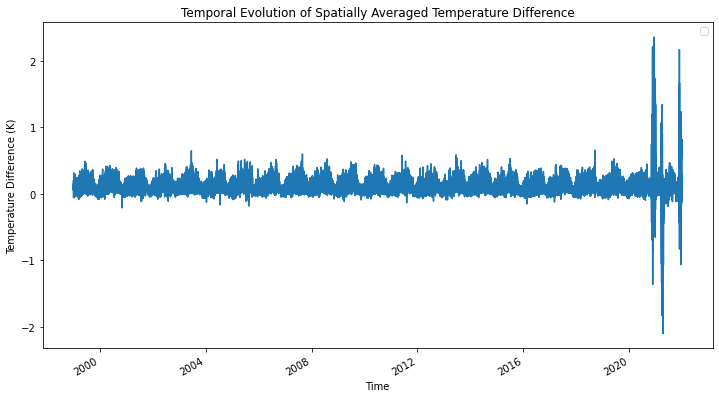

In [47]:
plt.figure(figsize=(12, 6))
# plt.plot(spatial_avg_diffs.time, spatial_avg_diffs.values, label='Spatial Average of Temperature Difference')
spatial_avg_diffs.plot()
plt.xlabel('Time')
plt.ylabel('Temperature Difference (K)')
plt.title('Temporal Evolution of Spatially Averaged Temperature Difference')
plt.legend()
plt.show()

A fourier analysis of the differe in time could offer some insight into the scales in which the temperature variations collect on.

In [ ]:
fft_spatial_avg_diff_temps = np.fft.fft(spatial_avg_diffs)
fft_freqs_spatial_avg_diff_temps = np.fft.fftfreq(spatial_avg_diffs.size, d=1/24)

In [ ]:
fft_result = fft_spatial_avg_diff_temps
fft_freqs = fft_freqs_spatial_avg_diff_temps

plt.figure(figsize=(10, 6))
plt.plot(fft_freqs, np.abs(fft_result), label='Magnitude')
plt.xlabel('Frequency (1/time)')
plt.ylabel('Magnitude')
plt.title('FFT of Spatially Averaged Temperature Differences')
plt.xlim(0, max(fft_freqs))
# plt.xlim(0.99,1.01)
plt.ylim(0,5000)
plt.legend()
plt.show()

The time averaged diff field:

In [21]:
time_avg_diffs = diff.mean(dim='time').squeeze()

In [22]:
data = time_avg_diffs
min_temp = -2
max_temp = 2

plt.figure(figsize=(15, 9))
# plt.style.use('ggplot')
mpl.rcParams['axes.prop_cycle'] = cycler(color=['black','grey',  'g', 'orange', 'y'])
# data = time_avg_diffs
ax = plt.subplot(1, 1, 1, projection=rotated_pole)
ax.add_feature(cfeature.BORDERS,edgecolor='grey')
ax.add_feature(cfeature.LAKES, edgecolor='grey', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='grey', facecolor='none')
ax.add_feature(cfeature.COASTLINE,edgecolor='grey')



#Heat map representing the time-averaged diff field
mesh = ax.pcolormesh(rlon, rlat, data, transform=rotated_pole, cmap='coolwarm',vmin=min_temp,vmax=max_temp)
plt.colorbar(mesh, orientation='horizontal', label='Temperature Difference (K)')

# Plot the station points (after plotting the field)
for station_key in stations:
    ax.scatter(stations[station_key].rotated_lat, stations[station_key].rotated_lon, label = stations[station_key].name,marker = '^')       
# ax.legend()
contour_fraction = ax.contour(rlon,rlat, data, transform=rotated_pole,colors='k',linewidths=0.5,levels = np.arange(0.0, 1.0, 0.1))
ax.clabel(contour_fraction,inline=True,fontsize=5,fmt="%.1f")
    


plt.title('TEB and Non-TEB Differences')
plt.show()

### 2.3.3 Seasonal Averages
The diff field generated will likely be more or less dramatic depending on the time of the year. The four seasons spatial (i.e. time-averaged across the spatial domain) fields are generated below.

In [34]:
seasonal_diff = diff.groupby('time.season')

time_avg_seasonal_diff = {}
for season in seasons: 
    time_avg_seasonal_diff[season] = seasonal_diff[season].mean(dim='time').squeeze() 

In [ ]:
sad = spatial_avg_diffs.groupby('time.season')
# saint_hubert_temps = saint_hubert.get_time_series('tas').grouby('time.season')
# mctavish_temps = mctavish.get_time_series().grouby('time.season')


for season in seasons:
    data = time_avg_seasonal_diff[season]
    min_temp = -2
    max_temp = 2
    
#     diff_avg = np.round(sad[season].mean(dim='time'),2)
    
#     diff_stations = round((mctavish_temps[season] - saint_hubert_temps[season]).mean(dim = 'time'),2)
    
    plt.figure(figsize=(15, 9))
    data = time_avg_seasonal_diff[season]
    ax = plt.subplot(1, 1, 1, projection=rotated_pole)
    ax.add_feature(cfeature.BORDERS,edgecolor='grey')
    ax.add_feature(cfeature.LAKES, edgecolor='grey', facecolor='none')
    ax.add_feature(cfeature.RIVERS, edgecolor='grey', facecolor='none')
    ax.add_feature(cfeature.COASTLINE,edgecolor='grey')
    
  
    # Heat map representing the time-averaged diff field
    mesh = ax.pcolormesh(rlon, rlat, data, transform=rotated_pole, cmap='coolwarm',vmin=min_temp,vmax=max_temp)
    plt.colorbar(mesh, orientation='vertical', label='Temperature Difference (K)')
    plt.title(f'TEB and Non-TEB Differences {season}')
    
    #Put in two stations for some graphics
    ax.scatter(mctavish.rotated_lat, mctavish.rotated_lon,label=mctavish.name,s=0.5,color='purple')
    ax.scatter(saint_hubert.rotated_lat, saint_hubert.rotated_lon,label=saint_hubert.name,s=0.5,color='green')
    
    ax.contour(rlon,rlat, data, transform=rotated_pole,colors='k',linewidths=0.5,levels = np.arange(0.0, 1.0, 0.1))
    ax.clabel(contour_fraction,inline=True,fontsize=5,fmt="%.1f")
    
    plt.legend(mesh, orientation='horizontal')
#     txt = f'T_diff = ~{diff_avg}K'
#     plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    plt.show()

In [ ]:
for season in seasons:
    print(sad[season].mean(dim='time'))

The mean may not offer as much insight as would spatial variance of the diff field. 

In [ ]:
time_avg_diff_stdev = diff.std(dim='time')

Seasonal and Diurnal Averages

In [51]:
diurnal_cycle_diff = diff.groupby('time.hour').mean(dim='time')
annual_cycle_diff = diff.groupby('time.dayofyear').mean(dim='time')

In [74]:
summer_diff = diff.groupby('time.season')['JJA'].groupby('time.hour').mean(dim='time')
winter_diff = diff.groupby('time.season')['DJF'].groupby('time.hour').mean(dim='time')

In [ ]:
# Specify a cycle to analyse from the box above, with the following properties:
cycle = diurnal_cycle_diff
cycle_name = "Diurnal Temperature Differences [TEB - NOTEB]"
unit = "Temperature Difference (K)"

# In this case the diurnal cycle uses hours
spatial_avg_cycle = cycle.mean(dim=['rlat', 'rlon'])
spatial_avg_cycle_summer = summer_diff.mean(dim=['rlat', 'rlon'])
spatial_avg_cycle_winter = winter_diff.mean(dim=['rlat','rlon'])

y = spatial_avg_cycle.values
x = spatial_avg_cycle['hour']

y1 = spatial_avg_cycle_summer.values
y2 = spatial_avg_cycle_winter.values


In [67]:
plt.figure()

# plt.plot(spatial_avg_diffs.time, spatial_avg_diffs.values, label='Spatial Average of Temperature Difference')
#spatial_avg_cycle.plot()


plt.plot(x,y, label= cycle_name) #default diurnal cycle
plt.plot(x,y1, label= 'summer case') 
plt.plot(x,y2, label = 'winter case')


plt.title('Average Cycle Over the Entire Spatial Domain')
plt.xlabel('Time')
plt.ylabel(unit)

plt.legend()
plt.show()

In [95]:
annual_cycle = {}
diurnal_cycle = {}
seasonal_cycle = {}

for season in allSeasons:
    seasonal_cycle[season] = {}
    for title in tas_keys:
        series = fields[title].mean(dim=['rlat', 'rlon'])
        
        if title not in annual_cycle:
            annual_cycle[title] = series.groupby('time.dayofyear').mean(dim='time')
        
        if season != 'All Seasons':
            series = series.groupby('time.season')[season]
        
        seasonal_cycle[season][title] = series.groupby('time.hour').mean(dim='time')

for title in tasmax_keys:
    series = fields[title].mean(dim=['rlat', 'rlon'])
    if title not in annual_cycle:
        annual_cycle[title] = series.groupby('time.dayofyear').mean(dim='time')

for title in tasmin_keys:
    series = fields[title].mean(dim=['rlat', 'rlon'])
    if title not in annual_cycle:
        annual_cycle[title] = series.groupby('time.dayofyear').mean(dim='time')
 
        series = fields[title].mean(dim=['rlat', 'rlon'])
        

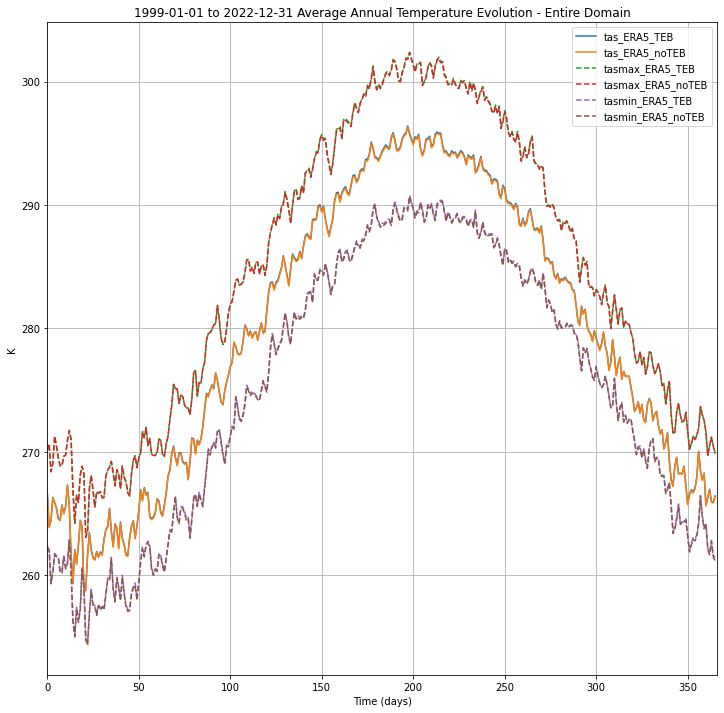

In [102]:
plt.figure(figsize=(12,12))
x = range(0,366) 

for title in annual_cycle:
    ls = 'solid'
    lc = 'red'
    
    if 'noTEB' in title:
        lc = 'blue'
    var_key = 'tas'
    if 'tasmin' in title or 'tasmax' in title:
        ls = 'dashed'
        if 'tasmin' in title:
            var_key = 'tasmin'
        else:
            var_key = 'tasmax'
    plt.plot(x,annual_cycle[title][var_key], label= title, linestyle = ls)

plt.title('Daily Temperature Averages Entire Domain')
plt.xlabel('Time (days)')
plt.ylabel('K')
plt.xlim(0,366)
plt.legend()
plt.title(f'1999-01-01 to 2022-12-31 Average Annual Temperature Evolution - Entire Domain')
plt.grid(True)
plt.show()

### Raw Differences

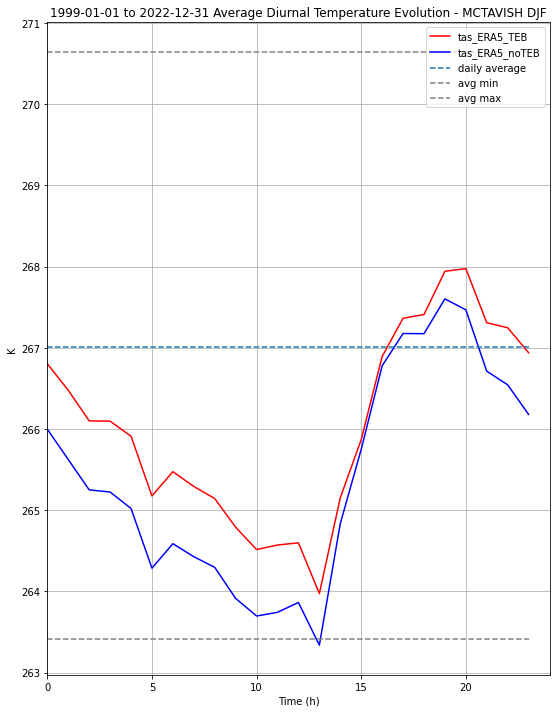

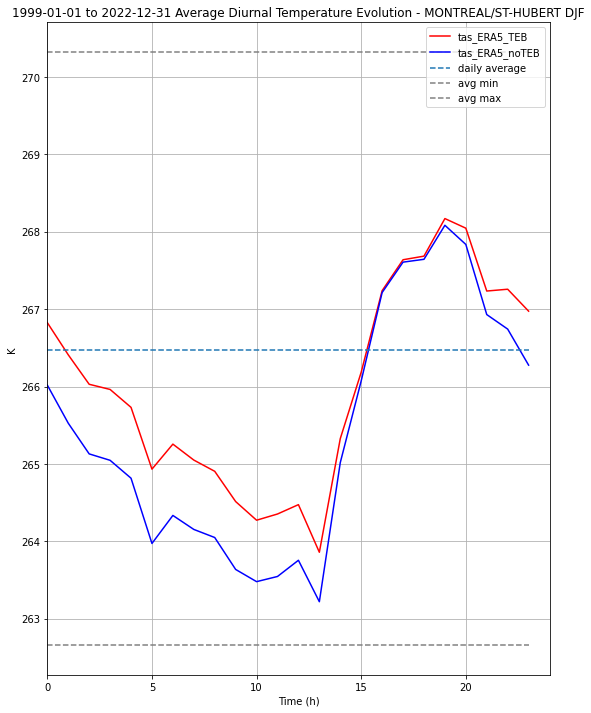

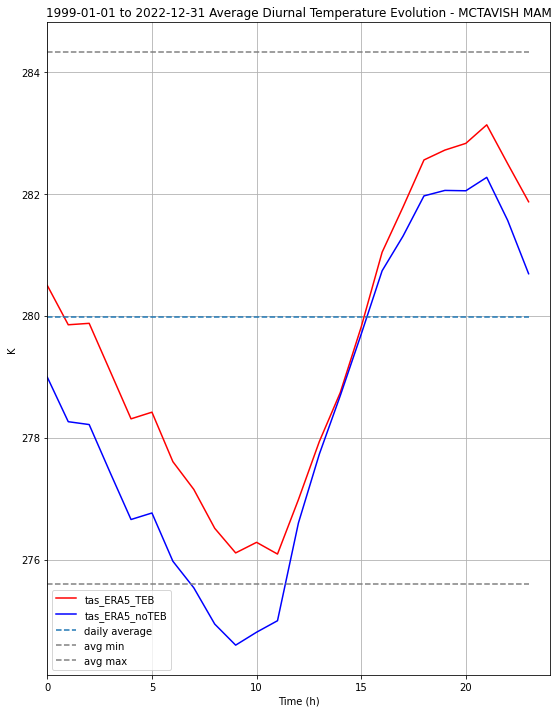

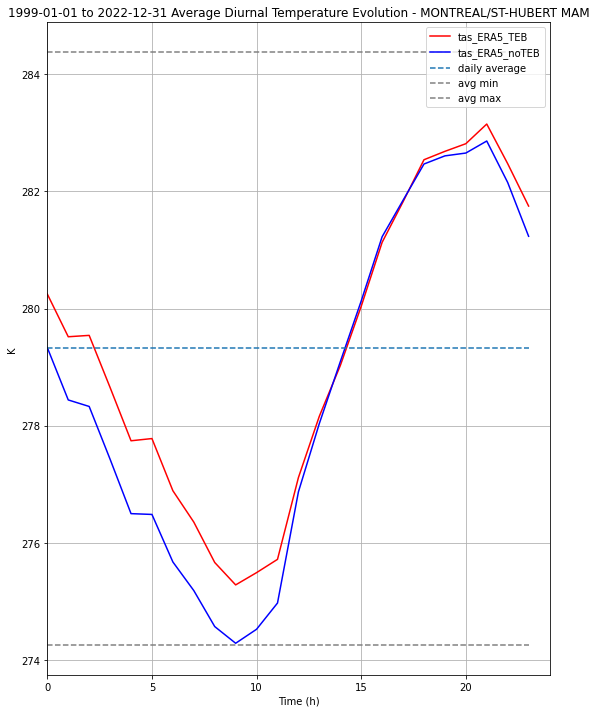

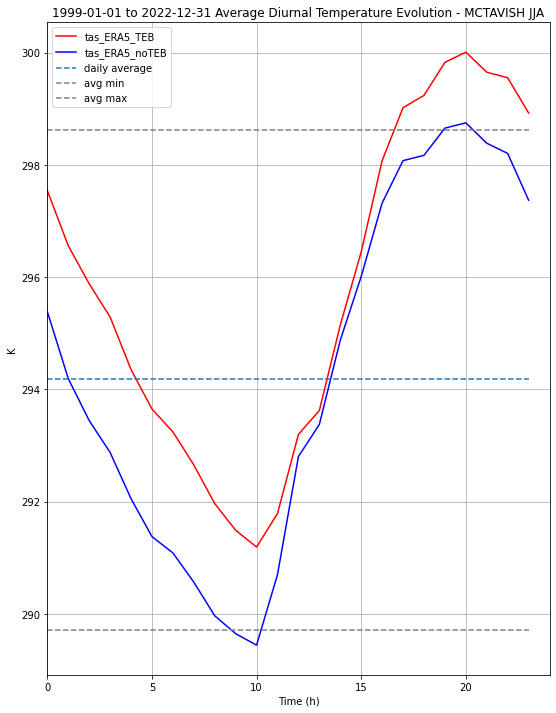

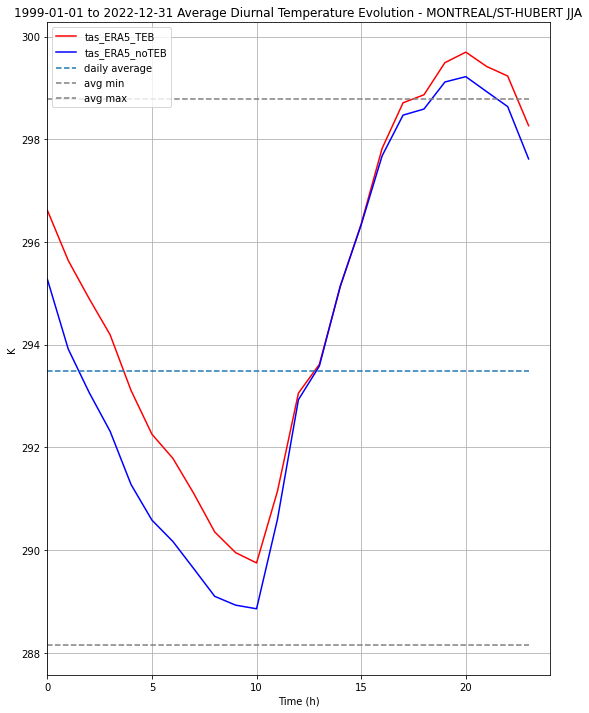

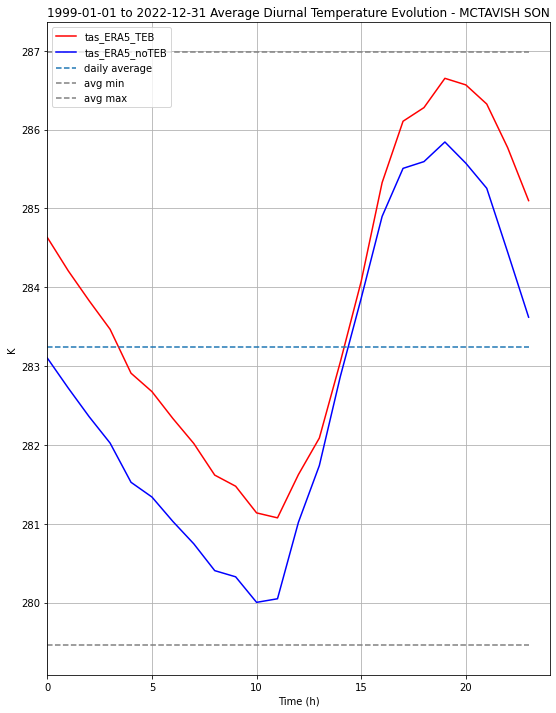

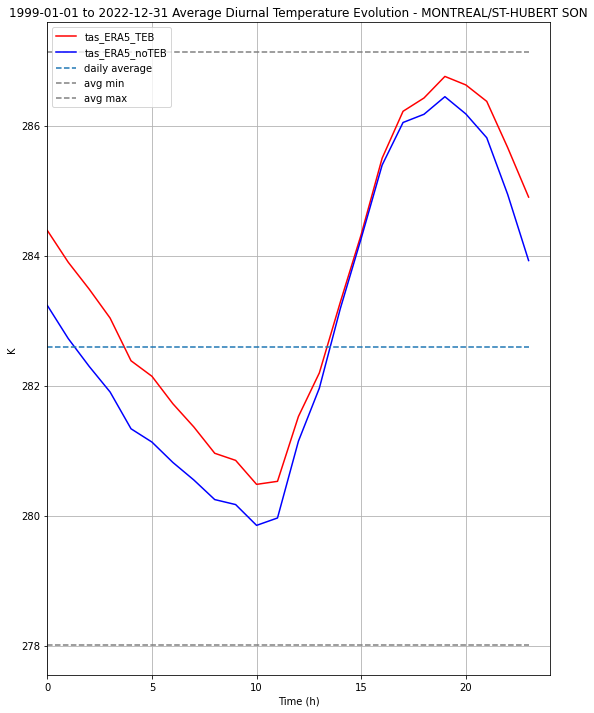

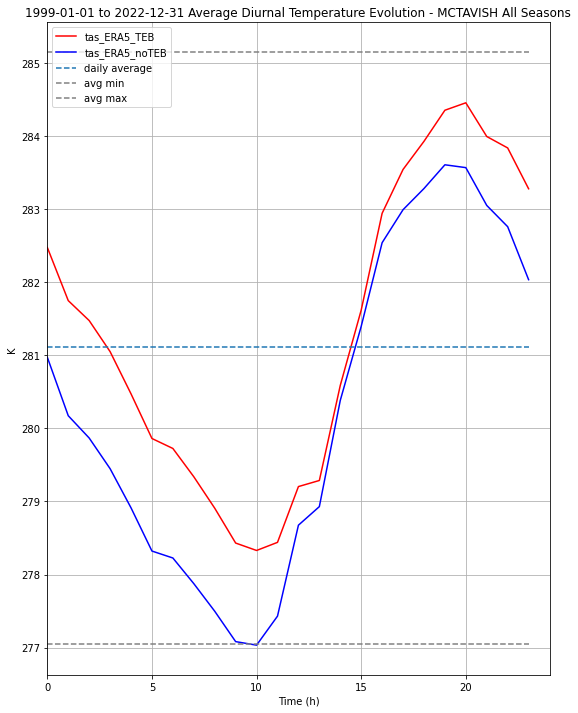

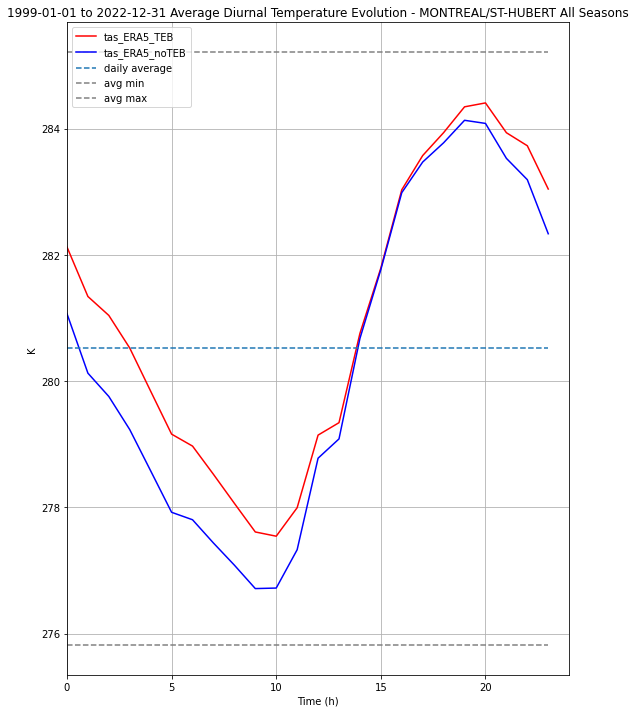

In [68]:
for season in allSeasons:
    for station_name in ['MCTAVISH', 'MONTREAL/ST-HUBERT']:
        for field_name_TEB,field_name_noTEB in zip(TEB_keys,noTEB_keys): 
            field_TEB = fields[field_name_TEB]
            field_noTEB = fields[field_name_noTEB]

            station = stations[station_name]
            times =  range(0,24)#field_TEB['time'].squeeze()

            station_times = station.daily_station_data['time'].squeeze()

            variable_name = 'tas'
            #Compare either tas, tasmax, or tasmin
            if field_name_TEB.startswith('tas_'):
                station_records = station.daily_station_data['tas']
                station_records = station_records.sel(time=slice('1999-01-01','2022-12-31')).squeeze() + 273.15
                
                station_maxes = station.daily_station_data['tasmax']
                station_maxes = station_maxes.sel(time=slice('1999-01-01','2022-12-31')).squeeze() + 273.15
                
                station_mins = station.daily_station_data['tasmin']
                station_mins = station_mins.sel(time=slice('1999-01-01','2022-12-31')).squeeze() + 273.15
                
#                 station.daily_station_data.sel(time=slice('1999-01-01','2022-12-31'))   
#                 if field_name_TEB.startswith('tasmax_'):
    #             station_records = station.daily_station_data['tasmax'].squeeze() + 273.15
    #             variable_name = 'tasmax'
    #         if field_name_TEB.startswith('tasmin_'):
    #             station_records = station.daily_station_data['tasmin'].squeeze() + 273.15
    #             variable_name = 'tasmin'

                series_TEB = station.get_time_series(field_TEB)[variable_name]
                series_noTEB = station.get_time_series(field_noTEB)[variable_name]
                
                if season != 'All Seasons':
                    series_TEB = series_TEB.groupby('time.season')[season]
                    series_noTEB = series_noTEB.groupby('time.season')[season]
                    station_records = station_records.groupby('time.season')[season]
                    station_maxes = station_maxes.groupby('time.season')[season]
                    station_mins = station_mins.groupby('time.season')[season]
                    
                
                series_TEB = series_TEB.groupby('time.hour').mean(dim ='time')
                series_noTEB = series_noTEB.groupby('time.hour').mean(dim ='time')
                station_records = station_records.groupby('time.hour').mean(dim ='time')
                station_maxes = station_maxes.groupby('time.hour').mean(dim ='time')      
                station_mins = station_mins.groupby('time.hour').mean(dim ='time')
                
                fig, axes = plt.subplots(figsize = (9,12))
                plt.plot(times,series_TEB  ,label = field_name_TEB, color= 'red')
                plt.plot(times, series_noTEB, label = field_name_noTEB, color = 'blue')

                plt.plot(times,station_records *np.ones(24), label = f'daily average',linestyle = 'dashed',color='green')
                plt.plot(times,station_mins *np.ones(24), label = 'avg min', linestyle = 'dashed', color = 'grey')
                plt.plot(times,station_maxes *np.ones(24), label = 'avg max', linestyle = 'dashed', color = 'grey')

                plt.xlabel('Time (h)')
                plt.ylabel('K')
                plt.xlim(0,24)
                plt.legend()
                plt.title(f'1999-01-01 to 2022-12-31 Average Diurnal Temperature Evolution - {station_name} {season}')
                plt.grid(True)
                plt.show()

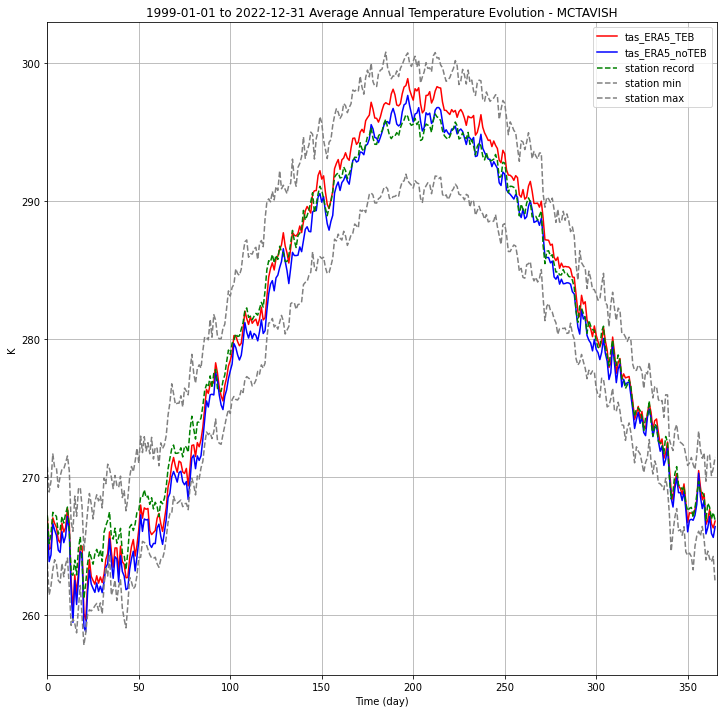

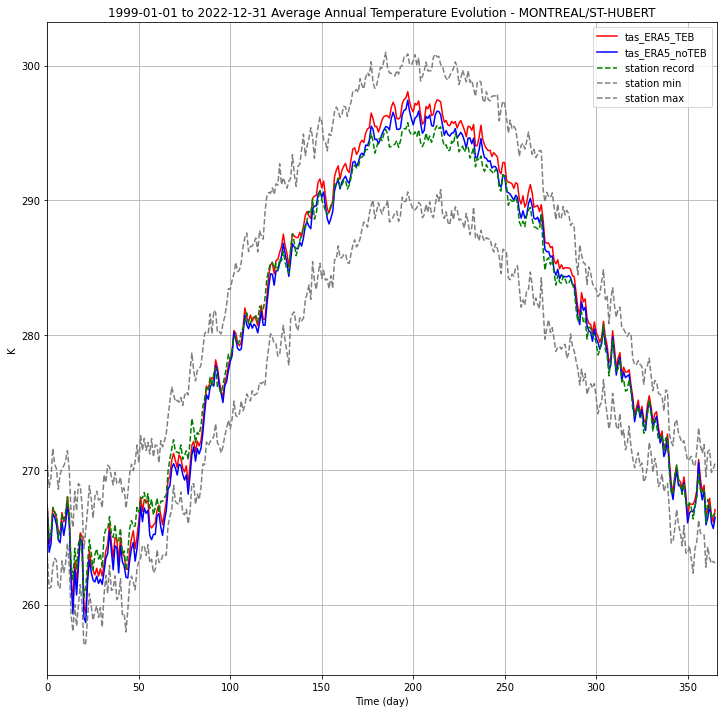

In [86]:
for station_name in ['MCTAVISH', 'MONTREAL/ST-HUBERT']:
    for field_name_TEB,field_name_noTEB in zip(TEB_keys,noTEB_keys): 
        if not ('min' in field_name_TEB) and not ('max' in field_name_TEB) :
            field_TEB = fields[field_name_TEB]
            field_noTEB = fields[field_name_noTEB]

            station = stations[station_name]
            times =  range(0,366)#field_TEB['time'].squeeze()

            station_times = station.daily_station_data['time'].squeeze()


            station_records = station.daily_station_data['tas']
            station_records = station_records.sel(time=slice('1999-01-01','2022-12-31')).squeeze() + 273.15

            station_maxes = station.daily_station_data['tasmax']
            station_maxes = station_maxes.sel(time=slice('1999-01-01','2022-12-31')).squeeze() + 273.15

            station_mins = station.daily_station_data['tasmin']
            station_mins = station_mins.sel(time=slice('1999-01-01','2022-12-31')).squeeze() + 273.15

            series_TEB = station.get_time_series(field_TEB)['tas']

            series_noTEB = station.get_time_series(field_noTEB)['tas']
#             maxes_noTEB = station.get_time_series(field_noTEB)['tasmax'].groupby('time.dayofyear').mean(dim ='time')
#             mins_noTEB = station.get_time_series(field_noTEB)['tasmin'].groupby('time.dayofyear').mean(dim ='time')

            series_TEB = series_TEB.groupby('time.dayofyear').mean(dim ='time')
            series_noTEB = series_noTEB.groupby('time.dayofyear').mean(dim ='time')
            station_records = station_records.groupby('time.dayofyear').mean(dim ='time')
            station_maxes = station_maxes.groupby('time.dayofyear').mean(dim ='time')      
            station_mins = station_mins.groupby('time.dayofyear').mean(dim ='time')

            fig, axes = plt.subplots(figsize = (12,12))
            plt.plot(times,series_TEB  ,label = field_name_TEB, color= 'red')
            plt.plot(times, series_noTEB, label = field_name_noTEB, color = 'blue')

            plt.plot(times,station_records, label = f'station record',color = 'green', linestyle = 'dashed')
            plt.plot(times,station_mins , label = 'station min', linestyle = 'dashed', color = 'grey')
            plt.plot(times,station_maxes , label = 'station max', linestyle = 'dashed', color = 'grey')



            plt.xlabel('Time (day)')
            plt.ylabel('K')
            plt.xlim(0,366)
            plt.legend()
            plt.title(f'1999-01-01 to 2022-12-31 Average Annual Temperature Evolution - {station_name}')
            plt.grid(True)
            plt.show()

### 2.3.4 Urban Fraction Impact on the Diff Field 

In [ ]:
time_avg_diffs_flat = time_avg_diffs.values.flatten()
urban_fraction_2d_flat = urban_fraction_2d.values.flatten()

# Mask NaN values
mask = ~np.isnan(time_avg_diffs_flat) & ~np.isnan(urban_fraction_2d_flat)
time_avg_diffs_flat = time_avg_diffs_flat[mask]
urban_fraction_2d_flat = urban_fraction_2d_flat[mask]

# Scatter plot
plt.scatter(urban_fraction_2d_flat, time_avg_diffs_flat, alpha=0.5, edgecolors='w', s=10)
plt.title('Correlation between Time Average Differences and Urban Fraction')
plt.xlabel('Urban Fraction')
plt.ylabel('Time Average Differences')
plt.grid(True)
plt.show()

# Calculating correlation coefficient
corr = np.corrcoef(urban_fraction_2d_flat, time_avg_diffs_flat)[0, 1]
print(f"Correlation coefficient: {corr:.2f}")

In [18]:
r = xr.corr(time_avg_diffs, urban_fraction_2d)
r

<xarray.DataArray ()>
dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    lev      float64 21.0

In [25]:
r.values

array(0.80140241)